In [112]:
import os
import csv
import numpy as np
# import icepyx as ipx
from os import listdir
from os.path import isfile, join
import h5py
import matplotlib.pylab as plt
from math import *
import random
import time


In [113]:
# Functions 

def dist(lon1,lat1,lon2,lat2):

  lon1_rad = np.radians(lon1)
  lon2_rad = np.radians(lon2)
  lat1_rad = np.radians(lat1)
  lat2_rad = np.radians(lat2)
  #Assumes degrees input
  #Calculates in metres
  R = 6371000 #Radius of earth in metres (roughly)
  ## Uses Haversine formula
  a1 = (sin((lat2_rad-lat1_rad)/2))**2
  a2 = (cos(lat1_rad))*(cos(lat2_rad))*((sin((lon2_rad-lon1_rad)/2))**2)
  a = a1 + a2
  c = 2*atan2(sqrt(a),sqrt(1-a))
  d = R*c

  return d

def get_chord_lengths(ice_leads_msk,fb_height,seg_dist_x):
    floe_chord_lengths = np.zeros(len(ice_leads_msk)) # Making big enough array
    floe_fb = np.zeros(len(ice_leads_msk)) # Making big enough array
    ice_cnt_st = 0
    ice_cnt_en = 0
    floe_idx = 1
    for i in range(1,len(ice_leads_msk)):
        if (ice_leads_msk[i] == 1) and (ice_leads_msk[i-1] == 0): # start floe
            ice_cnt_st = i
            ice_cnt_en = i
        elif (ice_leads_msk[i] == 1) and (ice_leads_msk[i-1] == 1): # grow floe
            ice_cnt_en += 1
        elif (ice_leads_msk[i-1] == 1) and (ice_leads_msk[i] == 0): # stop floe
            floe_chord_lengths[floe_idx] = seg_dist_x[ice_cnt_en] - seg_dist_x[ice_cnt_st]
            floe_fb[floe_idx] = np.mean(fb_height[ice_cnt_st:ice_cnt_en+1]) 
            floe_idx += 1
            
    # Removing spurious floes (< 10m, > 10 km, fb<0.1)
    remove_idx = np.where(floe_chord_lengths < 10)[0]  
    remove_idx = np.append(remove_idx,np.where(floe_chord_lengths > 10e3)[0])
    remove_idx = np.append(remove_idx,np.where(floe_fb < 0.1)[0])
    floe_fb = np.delete(floe_fb,remove_idx)
    floe_chord_lengths = np.delete(floe_chord_lengths,remove_idx)
    #
    return floe_chord_lengths, floe_fb

In [114]:
path = 'data/ATL10/Weddell/'
filelist = [file for file in os.listdir(path) if file.endswith('.h5')]
# filelist = filelist[0:2]

# # Initializing bin ranges
ITD_bin_ranges = np.linspace(0.1, 1.5, num=50)
ITD_bins = 0.5*(ITD_bin_ranges[0:-1] + ITD_bin_ranges[1:])

# Looping through h5 files in directory
mth_all = np.zeros(len(filelist))
cnt_file = 0
ITD_all = np.zeros((len(ITD_bins),len(filelist) ))
mth_all = np.zeros(len(filelist))
for fname in filelist:
    this_ATL10=h5py.File(path+fname, 'r')
    print(fname)
    #
    # Looping over beams. 
    # MG: CHANGE THIS TO ONLY INCLUDE STRONG BEAMS.
    fb_height_all_beams = []
    for beam in ['gt1l']: # ['gt1l','gt2l','gt3l','gt1r','gt2r','gt3r']:      
        # Getting data
        fb_height = np.array(np.squeeze(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/beam_fb_height']))
        fb_height = fb_height[(fb_height<1e38) & (fb_height>0.1)] 
        #
        # Appending across beams
        fb_height_all_beams = np.append(fb_height_all_beams,fb_height)
        
    # Getting binned statistics
    ITD, _ = np.histogram(fb_height_all_beams, bins=ITD_bin_ranges)
    
    # Appending across-files statistics
    ITD_all[:,cnt_file] = ITD
    mth_all[cnt_file] = int(fname.split('_')[1][4:6])
    cnt_file += 1



ATL10-02_20210203133757_06351001_005_01.h5
ATL10-02_20191208090337_11070501_005_02.h5
ATL10-02_20191025090101_04350501_005_02.h5
ATL10-02_20190301114641_09630201_005_02.h5
ATL10-02_20211030132017_05821301_005_01.h5
ATL10-02_20190317111321_12070201_005_02.h5
ATL10-02_20211014135334_03381301_005_01.h5
ATL10-02_20210303110522_10611001_005_01.h5
ATL10-02_20191031093538_05270501_005_02.h5
ATL10-02_20191005125113_01320501_005_02.h5
ATL10-02_20190905113210_10600401_005_02.h5
ATL10-02_20211103100324_06411301_005_01.h5
ATL10-02_20191002105936_00850501_005_02.h5
ATL10-02_20191104092718_05880501_005_02.h5
ATL10-02_20191013123433_02540501_005_02.h5
ATL10-02_20211203112222_11001301_005_01.h5
ATL10-02_20211021105400_04431301_005_01.h5
ATL10-02_20191030100118_05120501_005_02.h5
ATL10-02_20211119110427_08861301_005_01.h5
ATL10-02_20210208130358_07111001_005_01.h5
ATL10-02_20211020111939_04281301_005_01.h5
ATL10-02_20211108110341_07181301_005_01.h5
ATL10-02_20191010104255_02070501_005_02.h5
ATL10-02_20

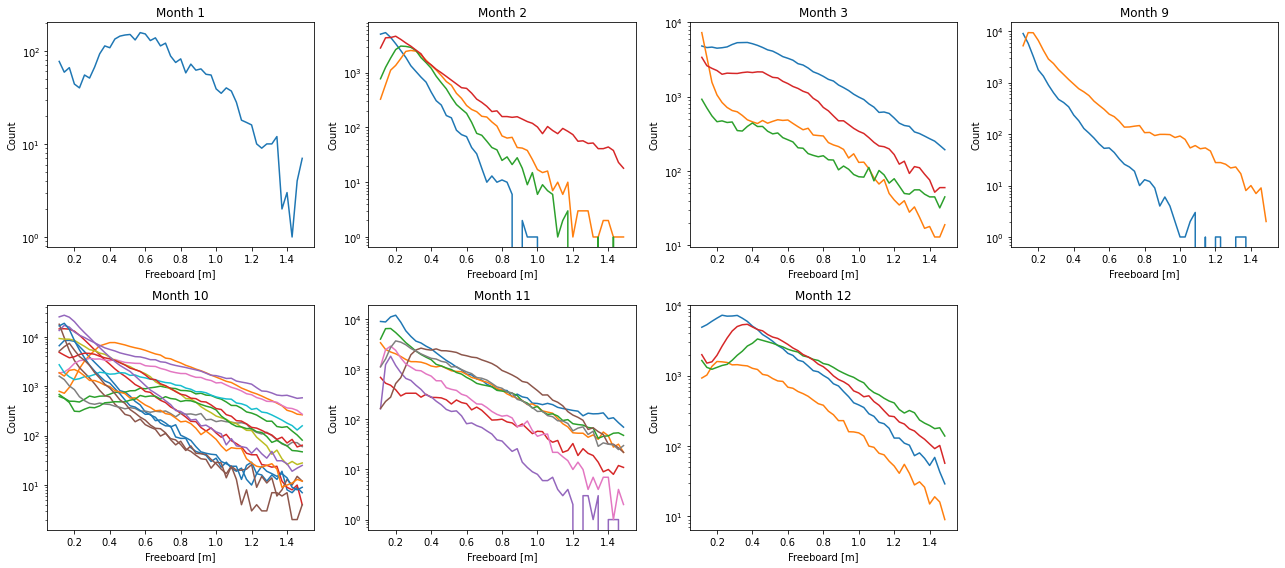

In [115]:
mths_labels = []
mths_unique = np.sort(np.unique(mth_all)) 
nmonths = len(mths_unique)

# fig, ax = plt.subplots(figsize = (15, 15),nrows=4, ncols=2)

fig = plt.figure(figsize = (18, 8))
for i in range(nmonths):
    mth = mths_unique[i]
    idx = np.where(mth_all == mth)[0]
    ax = fig.add_subplot(2, 4, i+1)
    ax.plot(ITD_bins,ITD_all[:,idx])
    ax.set_yscale("log")
    plt.xlabel('Freeboard [m]')
    plt.ylabel('Count')
    plt.title("Month "+str(int(mth)))

fig.tight_layout()